# Indicateur tourisme Paris

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import itertools
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## Réduction des données officielles à Paris

In [2]:
#Importe données groupées par mois
df_France_Official_Data2 = pd.read_csv("df_France_Official_Data_month.csv", index_col=0)
df_France_Official_Data2['date'] = pd.to_datetime(df_France_Official_Data2['date'])

In [10]:
#Données Paris
df_Official_Data_Paris = df_France_Official_Data2[df_France_Official_Data2['department']=='Paris']
df_Official_Data_Paris.head(5)

,date,department,value_in_thousands
71,2011-01-01,Paris,1106.32
167,2011-02-01,Paris,1020.39
263,2011-03-01,Paris,1314.42
359,2011-04-01,Paris,1329.35
455,2011-05-01,Paris,1390.83


In [11]:
#On regroupe par mois
df_Official_Data_Paris2 = df_Official_Data_Paris.groupby('date').sum() 
df_Official_Data_Paris2.head(5)

,value_in_thousands
date,
2011-01-01,1106.32
2011-02-01,1020.39
2011-03-01,1314.42
2011-04-01,1329.35
2011-05-01,1390.83


## Représentation de la série

<AxesSubplot:xlabel='date'>

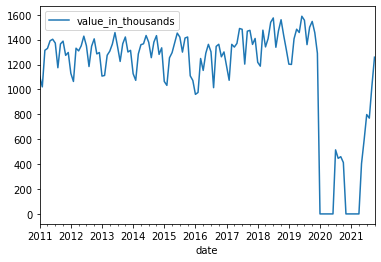

In [7]:
df_Official_Data_Paris2.plot()

In [12]:
#On se restreint à une période stable ie avant le confinement. On garde les obs avant 2020.
df_Official_Data_Paris2_index = df_Official_Data_Paris2.reset_index()
df_Official_Data_Paris3 = df_Official_Data_Paris2_index[df_Official_Data_Paris2_index['date']<"2020-01-01"]
df_Official_Data_Paris3.set_index('date', inplace=True)
df_Official_Data_Paris3

,value_in_thousands
date,
2011-01-01,1106.32
2011-02-01,1020.39
2011-03-01,1314.42
2011-04-01,1329.35
2011-05-01,1390.83
...,...
2019-08-01,1359.68
2019-09-01,1499.26
2019-10-01,1546.19


## Stationnarité Test ADF

In [13]:
#Methode 2 : Test ADF

result = adfuller(df_Official_Data_Paris3['value_in_thousands'])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -1.0134177883682087
p-value : 0.7483390665937513
Valeurs Critiques :
	1%: -3.5019123847798657
	5%: -2.892815255482889
	10%: -2.583453861475781


La statistique ADF est loin des valeurs critiques.   
La p-value est supérieure à 0,05 : on ne rejette pas H0 donc on ne rejette pas l'existence d'une racune unité. Donc la série temporelle n’est pas stationnaire.

### On stationnarise la série

In [14]:
#Différenciation de premier ordre
df_Official_Data_Paris3_diff = df_Official_Data_Paris3 - df_Official_Data_Paris3.shift()
df_Official_Data_Paris3_diff

,value_in_thousands
date,
2011-01-01,NaN
2011-02-01,-85.93
2011-03-01,294.03
2011-04-01,14.93
2011-05-01,61.48
...,...
2019-08-01,-195.98
2019-09-01,139.58
2019-10-01,46.93


Text(0.5, 1.0, 'Série différenciée')

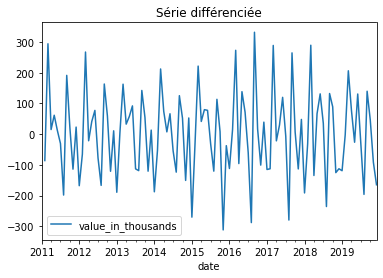

In [15]:
df_Official_Data_Paris3_diff.plot()
plt.title("Série différenciée")

In [16]:
#On supprime le NA 
df_Official_Data_Paris3_diff.dropna(inplace=True)

In [17]:
#Test ADF

result = adfuller(df_Official_Data_Paris3_diff['value_in_thousands'])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -4.001633015676509
p-value : 0.0014019844017470707
Valeurs Critiques :
	1%: -3.5011373281819504
	5%: -2.8924800524857854
	10%: -2.5832749307479226


La p-value est <0,05, la série est stationnaire.

## Décomposition

La décomposition d’une série temporelle consiste à séparer sa série initiale en plusieurs sous-séries plus simples, chacune représentant un aspect essentiel de la série initiale. Une décomposition typique est la décomposition en 3 séries: tendance, périodique et reste. On retrouve la série originale si on somme les 3 séries composantes.

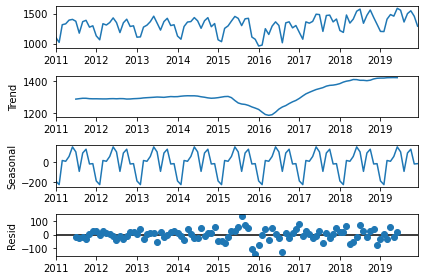

In [18]:
decompose = seasonal_decompose(df_Official_Data_Paris3, period=12)
decompose.plot()
plt.show()

## Fonction d'auto-corrélation (ACF) et d'auto-corrélation partielle (PACF)

Trois entiers (p, d, q) sont généralement utilisés pour paramétrer les modèles ARIMA :  
p : nombre de termes autorégressifs (ordre AR)  
d : nombre de différences non saisonnières (ordre de différenciation)  
q : nombre de termes moyens mobiles (ordre MA)  

Nous pouvons utiliser l’ACF pour déterminer le nombre optimal de termes MA. Nous pouvons utiliser le PACF pour déterminer le nombre optimal de termes à utiliser dans le modèle AR. 

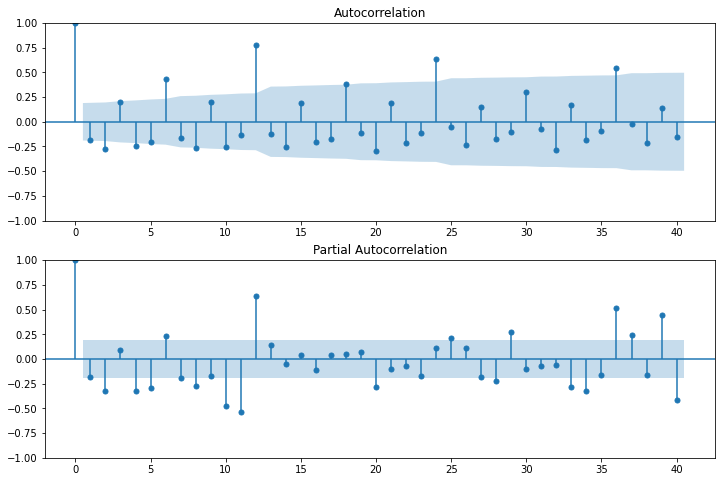

In [19]:
#sur la série différenciée

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_Official_Data_Paris3_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_Official_Data_Paris3_diff, lags=40, ax=ax2); 

## Modèle ARIMA

### Choix du modèle qui minimise l'AIC et le BIC

In [39]:
def choix_modele_arima(pmax, dmax, qmax, data):

    p = q = range(0,pmax)
    d = range(0,dmax)
    pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q

    parametres = {} # stores aic and order pairs
    parametres_bic = {}
    aics = [] # stores aics
    bics = []

    # Grid Search continued
    for param in pdq:
        try:
            model = ARIMA(data, order=param) # create all possible models
            model = model.fit()
            parametres.update({model.aic : param}) # store combinations
            parametres_bic.update({model.bic : param}) # store combinations
            aics.append(model.aic)
            bics.append(model.bic)

        except:
            continue

    best_aic = min(aics)
    best_bic = min(bics)

    print(best_aic)
    print(parametres[best_aic])

    print(best_bic)
    print(parametres_bic[best_bic])

In [40]:
choix_modele_arima(4,3,4, df_Official_Data_Paris3)

1308.8117373839027
(3, 1, 3)
1327.5215392251362
(3, 1, 3)


On fait un ARIMA(3,1,3)

### Modèle ARIMA

In [25]:
model = ARIMA(df_Official_Data_Paris3, order=(3,1,3)) #(p,d,q)
results_ARIMA = model.fit()
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     value_in_thousands   No. Observations:                  108
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -647.406
Date:                Fri, 15 Apr 2022   AIC                           1308.812
Time:                        22:25:37   BIC                           1327.522
Sample:                    01-01-2011   HQIC                          1316.396
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3198      0.108     -2.970      0.003      -0.531      -0.109
ar.L2         -0.3469      0.096     -3.630      0.000      -0.534      -0.160
ar.L3          0.6638      0.099      6.688      0.000       0.469       0.858
ma.L1         -0.0202      0.548     -0.037      0.971      -1.095       1.055
ma.L2          0.0091      0.508      0.018      0.986      -0.987       1.005
ma.L3         -0.9888      0.185     -5.347      0.000      -1.351      -0.626
sigma2      1.082e+04      0.000   1.03e+08      0.000    1.08e+04    1.08e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.30   Jarque-Bera (JB):                 5.38
Prob(Q):                              0.13   Prob(JB):                         0.07
Heteroskedasticity (H):               1.47   Skew:                            -0.54
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.75e+24. Standard errors may be unstable.
"""

### Résidus

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3198      0.108     -2.970      0.003      -0.531      -0.109
ar.L2         -0.3469      0.096     -3.630      0.000      -0.534      -0.160
ar.L3          0.6638      0.099      6.688      0.000       0.469       0.858
ma.L1         -0.0202      0.548     -0.037      0.971      -1.095       1.055
ma.L2          0.0091      0.508      0.018      0.986      -0.987       1.005
ma.L3         -0.9888      0.185     -5.347      0.000      -1.351      -0.626
sigma2      1.082e+04      0.000   1.03e+08      0.000    1.08e+04    1.08e+04


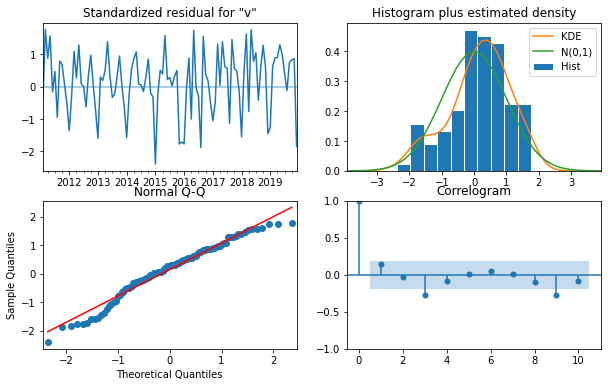

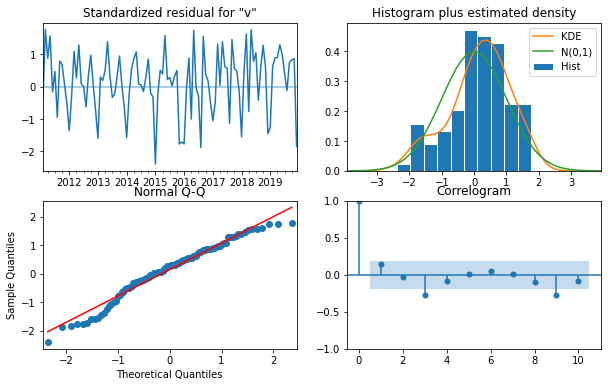

In [26]:
print(results_ARIMA.summary().tables[1])
#Check residuals
results_ARIMA.plot_diagnostics(figsize=(10, 6))

### Test portmanteau

In [28]:
residuals = pd.DataFrame(results_ARIMA.resid)
sm.stats.acorr_ljungbox(residuals)

,lb_stat,lb_pvalue
1,0.060624,0.805512
2,1.580517,0.453727
3,2.478445,0.479199
4,2.803806,0.591176
5,2.822331,0.727354
6,3.146255,0.790279
7,3.541724,0.830787
8,3.555914,0.894807
9,4.755335,0.855094
10,4.992007,0.891711


Les p-value sont toutes >5% : on ne rejette pas le modèle ARIMA(3,1,3)

### Prédiction

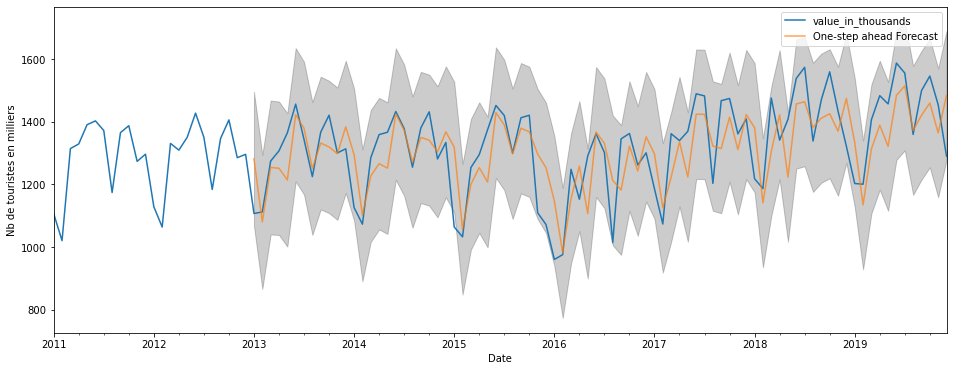

In [35]:
#A partir de 2013, on compare la prédiction aux valeurs officielles
pred = results_ARIMA.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_Official_Data_Paris3['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(16, 6))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Nb de touristes en milliers')
plt.legend()
plt.show()

#### RMSE

In [38]:
df_forecasted_ARIMA = pred.predicted_mean
df_truth = df_Official_Data_Paris3['2013-01-01':]

rmse = mean_squared_error(df_truth, df_forecasted_ARIMA, squared=False)
rmse

102.36006088002524

## SARIMA

The models notation is SARIMA(p, d, q).(P,D,Q)m

### Choix du modèle qui minimise l'AIC et le BIC

In [41]:
def choix_modele_sarima(pmax, dmax, qmax, data):

    p = range(0, pmax)
    q = range(0, qmax)
    d = range(0, dmax)
    pdq = list(itertools.product(p, d, q))

    p2 = d2 = q2 = range(0, 2)
    seasonal_pdq = list(itertools.product(p2,d2,q2))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in seasonal_pdq]
    
    parametres_aic = {}
    parametres_bic = {}
    aics = []
    bics = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                parametres_aic.update({results.aic : [param, param_seasonal]})
                parametres_bic.update({results.bic : [param, param_seasonal]})
                aics.append(results.aic)
                bics.append(results.bic)


            except: 
                continue

    best_aic = min(aics)
    print(best_aic)
    print(parametres_aic[best_aic])

    best_bic = min(bics)
    print(best_bic)
    print(parametres_bic[best_bic])
    
    return([best_aic, parametres_aic[best_aic], best_bic, parametres_bic[best_bic]])

In [42]:
choix_modele_sarima(5,3,5, df_Official_Data_Paris3)

867.8723262090666
[(0, 2, 4), (0, 1, 1, 12)]
881.9351587401887
[(0, 2, 4), (0, 1, 1, 12)]


[867.8723262090666,
 [(0, 2, 4), (0, 1, 1, 12)],
 881.9351587401887,
 [(0, 2, 4), (0, 1, 1, 12)]]

Les résultats avec l'AIC et le BIC suggèrent que le meilleur modèle c'est SARIMAX(0, 2, 4)x(0, 1, 1, 12).

### Modélisation

In [43]:
mod = sm.tsa.statespace.SARIMAX(df_Official_Data_Paris3,
                                order=(0, 2, 4),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_SARIMA = mod.fit()
print(results_SARIMA.summary())

                                      SARIMAX Results                                       
Dep. Variable:                   value_in_thousands   No. Observations:                  108
Model:             SARIMAX(0, 2, 4)x(0, 1, [1], 12)   Log Likelihood                -427.936
Date:                              Fri, 15 Apr 2022   AIC                            867.872
Time:                                      22:58:37   BIC                            881.935
Sample:                                  01-01-2011   HQIC                           873.497
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4576     48.854     -0.030      0.976     -97.209      94.294
ma.L2          0.37

Aucune p-value n'est significative.

### Résidus

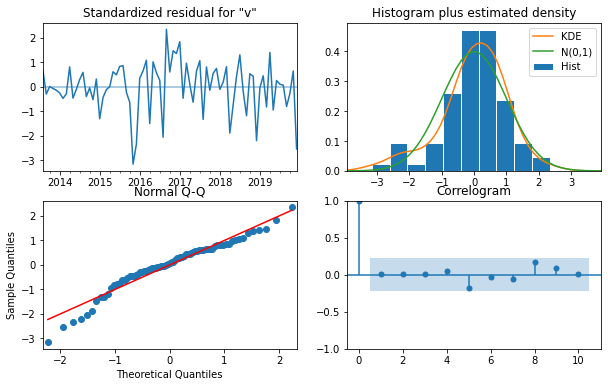

In [44]:
results_SARIMA.plot_diagnostics(figsize=(10, 6))
plt.show()

Le graphique de autocorrélations des résidus est bien.

### Tests portmanteaux

In [45]:
residuals_sarima = pd.DataFrame(results_SARIMA.resid)
sm.stats.acorr_ljungbox(residuals_sarima)

,lb_stat,lb_pvalue
1,37.020338,1.169035e-09
2,42.969172,4.670495e-10
3,43.670993,1.772656e-09
4,43.809448,7.027881e-09
5,43.812229,2.528671e-08
6,44.334592,6.344462e-08
7,48.009263,3.545793e-08
8,50.617712,3.108736e-08
9,51.039336,6.864195e-08
10,55.653266,2.383885e-08


Les p-value sont toutes <5% : on rejette le modèle SARIMAX(0, 2, 4)x(0, 1, 1, 12)

### Prévision

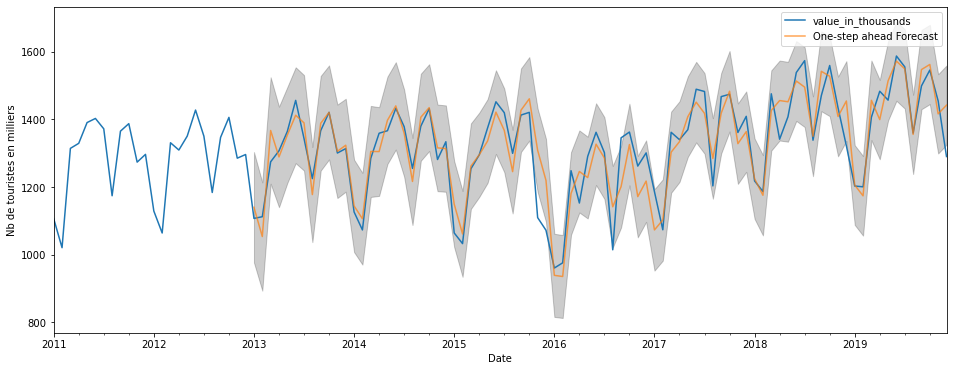

In [47]:
pred = results_SARIMA.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_Official_Data_Paris3['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(16, 6))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Nb de touristes en milliers')
plt.legend()
plt.show()

#### RMSE

In [48]:
df_forecasted = pred.predicted_mean
df_truth = df_Official_Data_Paris3['2013-01-01':]

rmse = mean_squared_error(df_truth, df_forecasted, squared=False)
rmse

60.8481346760504

#### Prédiction valeurs futures

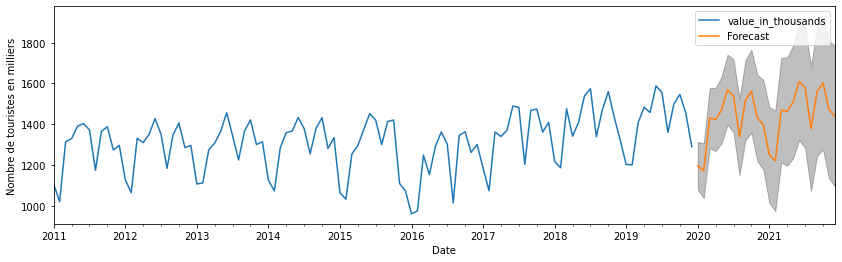

In [49]:
pred_uc = results_SARIMA.get_forecast(steps=24) #je prédis le nombre de touristes pour les 24 prochains mois
pred_ci = pred_uc.conf_int()
ax = df_Official_Data_Paris3.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Nombre de touristes en milliers')
plt.legend()
plt.show()

## Prédiction en temps réel, qui intègre les nouvelles données

In [50]:
df_Official_Data_Paris2.head(3)

,value_in_thousands
date,
2011-01-01,1106.32
2011-02-01,1020.39
2011-03-01,1314.42


In [51]:
df_Official_Data_Paris2_index.head(3)

,date,value_in_thousands
0,2011-01-01,1106.32
1,2011-02-01,1020.39
2,2011-03-01,1314.42


In [52]:
#on imagine que l'on a toutes les données jusqu'à décembre 2017 de disponible
df_donnees_dispo = df_Official_Data_Paris2_index[df_Official_Data_Paris2_index['date']<"2018-01-01"]
df_donnees_dispo.set_index('date', inplace=True)

#on fit le modèle SARIMA(0, 2, 4)x(0, 1, 1, 12) sur ces données
modele_prev = sm.tsa.statespace.SARIMAX(df_donnees_dispo,
                                        order=(0, 2, 4),
                                        seasonal_order=(0, 1, 1, 12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

resultats_prev = modele_prev.fit()

In [53]:
#on crée le dataframe des prévisions qu'on va remplir au fur et à mesure

df_forecast = pd.DataFrame(columns=['date', 'valeur_predite','donnee_officielle'])
df_forecast['date'] = df_Official_Data_Paris2_index['date'][(df_Official_Data_Paris2_index['date']<'2021-10-01') &
                                                           (df_Official_Data_Paris2_index['date']>="2018-01-01")]
df_forecast.set_index('date', drop=False, inplace=True)

In [54]:
resultats_prev_new = resultats_prev

for date in df_forecast['date']:
      
    #La valeur prédite :
    df_forecast.loc[date, 'valeur_predite'] = float(resultats_prev_new.forecast(date)) 
    #je mets dans le dataframe la prédiction pour la date

    # La nouvelle observation qu'on a à disposition
    new_data = df_Official_Data_Paris2.loc[date, "value_in_thousands"]
    
    #La nouvelle observation qu'on a à disposition (sous forme de dataframe) :
    new_data2 = df_Official_Data_Paris2_index[df_Official_Data_Paris2_index['date']==date]
    new_data2.set_index('date', inplace=True)
        
    #On met la nouvelle observation dans le dataframe
    df_forecast.loc[date, 'donnee_officielle'] = new_data
    
    #Nouveau modèle fitté avec une donnée de plus :
    resultats_prev_new = resultats_prev_new.append(new_data2)

df_forecast    


,date,valeur_predite,donnee_officielle
date,,,
2018-01-01,2018-01-01,1232.38847,1218.0
2018-02-01,2018-02-01,1185.733239,1186.79
2018-03-01,2018-03-01,1426.952826,1476.04
2018-04-01,2018-04-01,1472.541902,1341.51
2018-05-01,2018-05-01,1447.988143,1407.96
2018-06-01,2018-06-01,1497.459244,1538.97
2018-07-01,2018-07-01,1502.726331,1574.13
2018-08-01,2018-08-01,1378.616668,1338.58
2018-09-01,2018-09-01,1538.035614,1470.74


<AxesSubplot:xlabel='date'>

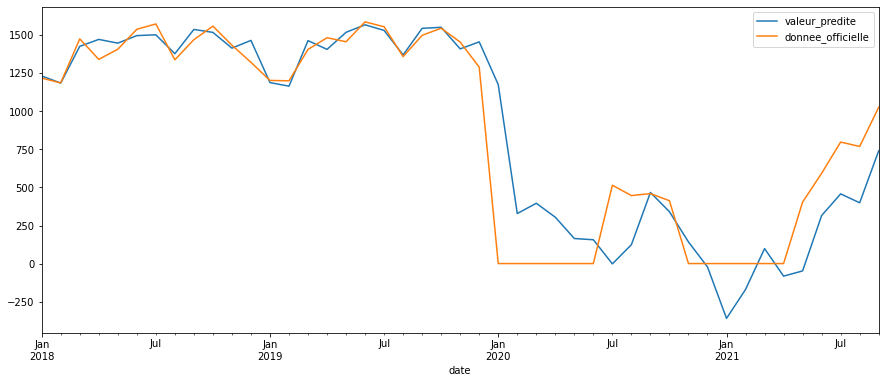

In [55]:
df_forecast[['valeur_predite','donnee_officielle']].plot(figsize=(15,6))